# Power AutoCorrelation Strategy

This model is based on the German power auto-correlation strategy proposed by [Narro, J., and M. Caamano. Systematic Trading in Energy Markets. London, UK: Risk Books, 2020.]
Adding the constraint of long only, an end-of-day buy signal is generated using a simple rule: If the difference in price from yesterday’s close to today’s is positive,then go long at today’s close, else exit the position.
$$y_{t} = 
\begin{cases}
1, & \quad \text{if $\Delta r_{t} > 0$}\\
y_{t-1}, & \quad \text{if $\Delta r_{t} = 0$}\\
0, & \quad \text{if $\Delta r_{t} < 0$}
\end{cases} 
$$
where $y_{t}$ is the side of position, $y_{t} \in {0, 1}$, and $\Delta r_{t}$ is the difference in returns between  $r_{t} - r_{t-1}$.

[Jacques Francois Joubert, Meta-Labeling: Theory and  Framework, 2022]


In [1]:
from datetime import datetime

from hg_oap.dates.calendar import WeekendCalendar
from hg_oap.dates.date_services import business_days, business_days_from_calendar
from hgraph import register_service, default_path, lag, if_then_else, feedback, TS, drop_dups, sample, sum_, count, if_true
from hgraph.notebook import start_wiring_graph
from matplotlib import pyplot as plt

from hg_systematic.data.generators import auto_regressive_generator, white_noise_generator, random_

In [2]:
start_wiring_graph("power_autocorrelation_strategy", start_time=datetime(2023, 1, 1), end_time=datetime(2024, 1, 1))
register_service(default_path, business_days_from_calendar, calendar_tp=WeekendCalendar)

In [3]:
dt = business_days()

In [4]:
noise = white_noise_generator(dt)

In [5]:
values = noise.eval()
data = {"date": [v[0] for v in values], "value": [v[1] for v in values]}

2024-11-03 16:57:34,820 [hgraph][DEBUG] Creating graph engine: EvaluationMode.SIMULATION
2024-11-03 16:57:34,820 [hgraph][DEBUG] Starting to run graph from: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
2024-11-03 16:57:34,820 [hgraph][WARNING] /Users/hhenson/PycharmProjects/hg_systematic/.venv/lib/python3.12/site-packages/hgraph/_impl/_runtime/_evaluation_clock.py:54: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
2024-11-03 16:57:34,831 [hgraph][DEBUG] Finished running graph


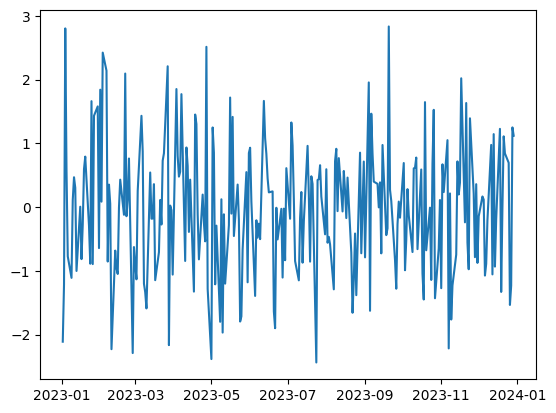

In [6]:
plt.plot(data["date"], data["value"])

To simulate market conditions, we make use of two autoregressive generators. One produces a signal sympathetic to the strategy, the other counter sympathetic.
We then randomly select 30 data points from these two generators based on the value of a random number to achieve a roughly 80% sympathetic data stream and 20% counter.
For now, we use the white noise generator as a source of random numbers to make use of.

In [7]:
returns_positive = auto_regressive_generator(noise, order=3, initial_values=(0.032, 0.02, -0.042), 
                                             coefficients=(0.0, 0.25, -0.2, 0.35))
returns_negative = auto_regressive_generator(noise, order=3, initial_values=(0.032, 0.02, -0.042),
                                    coefficients=(-0.0001, -0.25, 0.2, -0.35))
sample_count = count(dt) - 1 # Count the dates we generate the noise / signal on, offset to starting at 0 and not 1
sampled_random_value = random_(if_true(sample_count % 30 == 0))  # Now we sample the noise every 30 ticks (this will also tick on the first tick of dt)
use_positive_signal = sampled_random_value <= 0.8 
returns = if_then_else(use_positive_signal, returns_positive, returns_negative)  # If less then 80% use the positive returns otherwise use negative returns.

In [8]:
values = returns.eval()
returns_data = {"date": [v[0] for v in values], "value": [v[1] for v in values]}

2024-11-03 16:57:34,939 [hgraph][DEBUG] Creating graph engine: EvaluationMode.SIMULATION
2024-11-03 16:57:34,940 [hgraph][DEBUG] Starting to run graph from: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
2024-11-03 16:57:34,940 [hgraph][WARNING] /Users/hhenson/PycharmProjects/hg_systematic/.venv/lib/python3.12/site-packages/hgraph/_impl/_runtime/_evaluation_clock.py:54: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
2024-11-03 16:57:34,952 [hgraph][DEBUG] Finished running graph


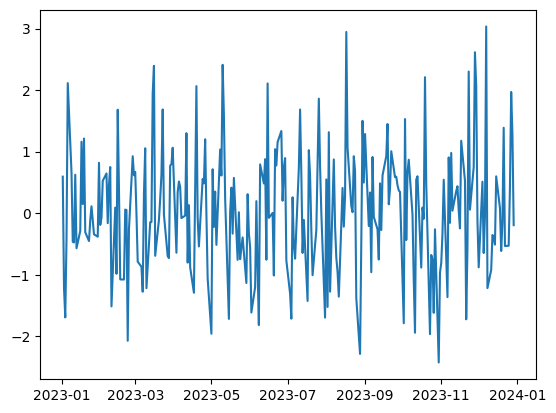

In [9]:
plt.plot(returns_data["date"], returns_data["value"])

Since we are running off of a signal for generating returns, we can use a lag based on a tick-by-tick lag (of 1) to get the previous return.
Next for the signal, we want to split this into three cases, where one of the cases result depends on the previous state of the signal.
We track the previous value by using a ``feedback`` to return the last value of the signal to ourselves. This will tick the value of the signal
one ``MIN_TD`` or in this case 1 micro-second later (the smallest time-delta for an engine cycle).
We can then lag the signal by 1 to ensure we get the previous result. 

    This does create a small problem in that the previous signal (if selected) will tick again in 1 mirco seconds time. (The ``drop_dups`` helps clean this up)

The conditional logic is split into two ``if_then_else`` clauses. To reduce computation, we perform a ``drop_dups`` to only tick the feedback (and related logic)
if the value of the signal changes.

Finally, to ensure that we get a tick of signal value for each day we are computing it for, we sample the signal value using the ``dt`` at a timer.

In [10]:
delta_r = returns - lag(returns, period=1)
fb = feedback(TS[float], 0.0)
signal_prev = lag(fb(), period=1)
signal = drop_dups(if_then_else(delta_r == 0.0, signal_prev, if_then_else(delta_r > 0.0, 1.0, 0.0)))
fb(signal)
signal = sample(dt, signal)

In [11]:
values = signal.eval()
signal_data = {"date": [v[0] for v in values], "value": [v[1] for v in values]}

2024-11-03 16:57:35,117 [hgraph][DEBUG] Creating graph engine: EvaluationMode.SIMULATION
2024-11-03 16:57:35,118 [hgraph][DEBUG] Starting to run graph from: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
2024-11-03 16:57:35,118 [hgraph][WARNING] /Users/hhenson/PycharmProjects/hg_systematic/.venv/lib/python3.12/site-packages/hgraph/_impl/_runtime/_evaluation_clock.py:54: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
2024-11-03 16:57:35,140 [hgraph][DEBUG] Finished running graph


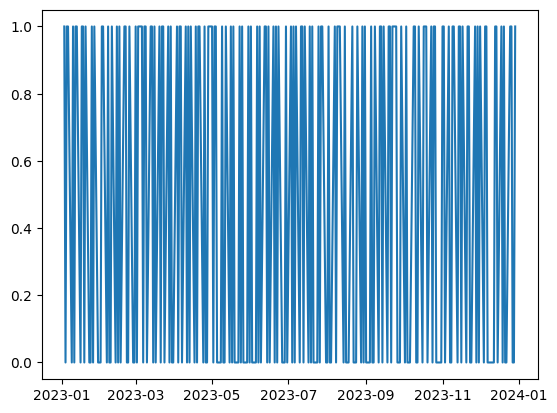

In [12]:
plt.plot(signal_data["date"], signal_data["value"])

To compute a pseudo pnl we assume the signal equates to holding a position in instrument associated with the return. We then will gain the return by holding the position for a business day. Thus, yesterday's signal * today's return gives us the return we earned today. We then sum the pnl from inception until now to get the cumulative pnl for the strategy. 

In [13]:
pnl = lag(signal, period=1) * returns  # Yesterday's signal * today's return = pnl
cum_pnl = sum_(pnl)

In [14]:
values = cum_pnl.eval()
cum_pnl_data = {"date": [v[0] for v in values], "value": [v[1] for v in values]}

2024-11-03 16:57:35,269 [hgraph][DEBUG] Creating graph engine: EvaluationMode.SIMULATION
2024-11-03 16:57:35,270 [hgraph][DEBUG] Starting to run graph from: 2023-01-01 00:00:00 to 2024-01-01 00:00:00
2024-11-03 16:57:35,270 [hgraph][WARNING] /Users/hhenson/PycharmProjects/hg_systematic/.venv/lib/python3.12/site-packages/hgraph/_impl/_runtime/_evaluation_clock.py:54: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
2024-11-03 16:57:35,294 [hgraph][DEBUG] Finished running graph


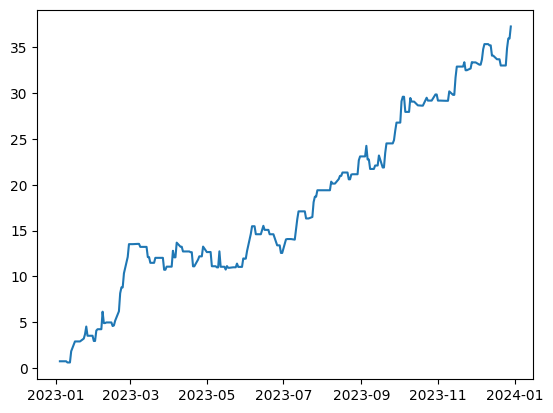

In [15]:
plt.plot(cum_pnl_data["date"], cum_pnl_data["value"])